In [19]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy.stats

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
# Start by loading the data

training_path = "CinC2017Data/training2017/training2017/"
answers_path = "CinC2017Data/REFERENCE-v3.csv"

dataset = pd.read_csv(answers_path, header=None, names=["class"], index_col=0)
dataset["data"] = None

print(dataset.head())

for root, dirs, files in os.walk(training_path):
    for name in files:
        try:
            name, ext = name.split(".")
        except ValueError:
            print("error, scipping file")
            continue
        if ext == "mat":
            mat_data = scipy.io.loadmat(os.path.join(root, name+"."+ext))
            dataset.loc[name]["data"] = mat_data["val"]
            print(f"Adding {name}\r", end="")

print(dataset.head())
pk_path = "CinC2017Data/database.pk"
dataset.to_pickle(pk_path)

In [2]:
dataset = pd.read_pickle("CinC2017Data/database.pk")

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [9]:
def get_power_ratios(data):
    N = data.shape[-1]
    fft = np.fft.fft(data[0])
    fftfreq = np.fft.fftfreq(data.shape[-1], 1/300.0)

    fft_low_freq = fft[fftfreq < 5]
    fft_med_freq = fft[np.logical_and(fftfreq > 5, fftfreq < 40)]
    fft_high_freq = fft[fftfreq > 40]

    total_power = 1/N * np.sum(np.abs(fft) ** 2)

    return np.array([((1/f.shape[0]) * np.sum(np.abs(f) ** 2))/total_power for f in (fft_low_freq, fft_med_freq, fft_high_freq)])

dataset["mean"] = dataset["data"].map(np.mean)
dataset["std_dev"] = dataset["data"].map(np.std)
dataset["skewness"] = dataset["data"].map(lambda x: scipy.stats.skew(x[0], axis = -1))
dataset["kurtosis"] = dataset["data"].map(lambda x: scipy.stats.kurtosis(x[0], axis = -1))
dataset["low_freq_power"] = dataset["data"].map(lambda x: get_power_ratios(x)[0])
dataset["med_freq_power"] = dataset["data"].map(lambda x: get_power_ratios(x)[1])
dataset["high_freq_power"] = dataset["data"].map(lambda x: get_power_ratios(x)[2])

A00001    [[-127, -162, -197, -229, -245, -254, -261, -2...
A00002    [[128, 157, 189, 226, 250, 257, 262, 265, 268,...
A00003    [[56, 73, 85, 93, 100, 107, 113, 117, 118, 117...
A00004    [[519, 619, 723, 827, 914, 956, 955, 934, 920,...
A00005    [[-188, -239, -274, -316, -356, -374, -380, -3...
                                ...                        
A08524    [[-104, -127, -144, -154, -160, -164, -168, -1...
A08525    [[-121, -197, -288, -390, -496, -600, -693, -7...
A08526    [[-202, -235, -272, -305, -325, -339, -344, -3...
A08527    [[-227, -297, -374, -449, -505, -527, -539, -5...
A08528    [[-237, -286, -338, -390, -425, -437, -443, -4...
Name: data, Length: 8528, dtype: object


In [10]:
dataset.groupby("class").mean()

C:\Users\daniel\AppData\Local\Temp\ipykernel_21956\4048640478.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dataset.groupby("class").mean()


,mean,std_dev,skewness,kurtosis,low_freq_power,med_freq_power,high_freq_power
class,,,,,,,
A,9.201373,191.132486,1.005747,12.629672,1.503035,1.909598,0.001330
N,7.816593,205.241519,0.967829,14.135141,1.566843,1.628036,0.000998
O,6.896023,203.619693,0.975718,13.955079,1.541510,1.740481,0.000931
~,3.659158,440.865250,0.008933,13.397683,1.742798,0.839657,0.003754


In [12]:
very_clean = dataset[(dataset["class"] == "N") & (dataset["skewness"] >= 1) & (dataset["high_freq_power"] <= 0.001) & (dataset["std_dev"] <= 200)]
print(len(very_clean.index))

1002


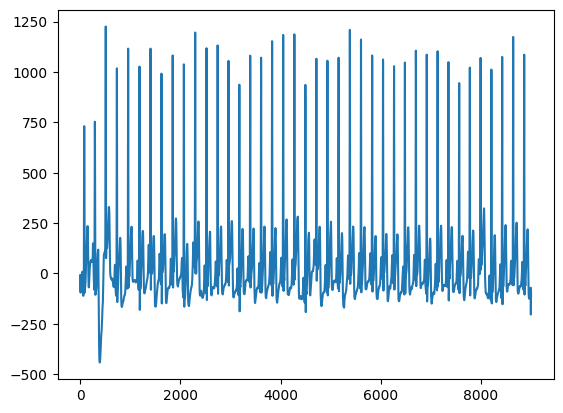

In [32]:
plt.plot(very_clean.iloc[192]["data"][0])
plt.show()

In [42]:
very_noisy = dataset[(dataset["class"] == "~") & (dataset["skewness"] <= 0.1) & (dataset["std_dev"] >= 400)]
print(len(very_noisy.index))

78


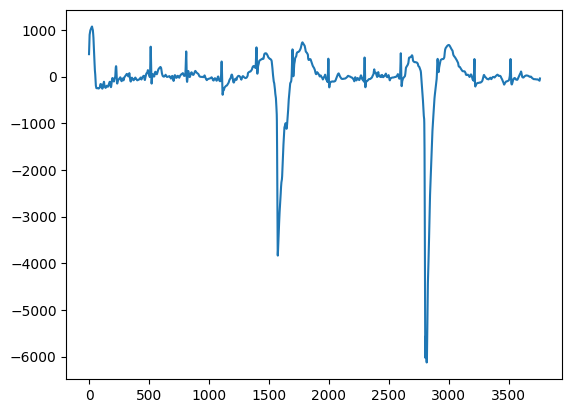

In [44]:
plt.plot(very_noisy.iloc[3]["data"][0])
plt.show()

In [20]:
c = "N"

num_rows = 1
num_cols = 1

num_class_samples = num_cols * num_rows
fig = make_subplots(rows=num_rows, cols=num_cols)

for i, (_, sample) in enumerate(very_clean[very_clean["class"] == c].sample(num_class_samples).iterrows()):
    fig.add_trace(go.Scatter(y=sample["data"][0]), row=i%num_cols + 1, col = i//num_rows + 1)

fig.update_layout(height=1000)
fig.update_xaxes(title="sample number")
fig.update_yaxes(title="amplitude")
fig.show()

In [15]:
def generate_index(c):
    if c == "N":
        return 0
    if c == "O":
        return 1
    if c == "A":
        return 2
    if c == "~":
        return 3

# dataset["onehot"] = dataset["class"].map(generate_onehot)
dataset["class_index"] = dataset["class"].map(generate_index)

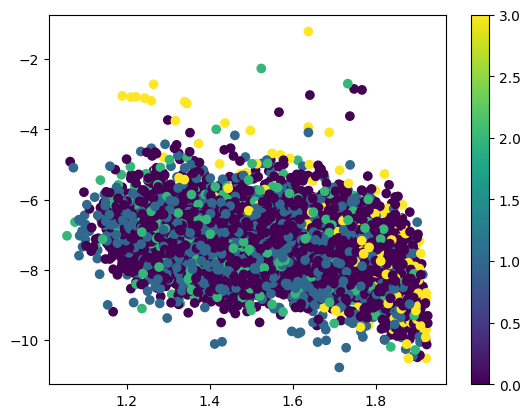

In [23]:
# Compare the power ranges

scatter = plt.scatter(dataset["low_freq_power"], np.log(dataset["high_freq_power"]), c=dataset["class_index"], cmap="viridis")
plt.colorbar(scatter)
plt.show()